<h1> <div align="center"><a> Выявление закономерностей, определяющих успешность компьютерных игр </a></div>

## Изучение данных из файла

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


Сразу видим, что названия столбцов необходимо преобразовать, поскольку в их именах строчные буквы сочетаются с прописными.

In [3]:
#оценим общий массив данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица имеет 16715 строк и 11 столбцов. Видим пропущенные значения в столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score и Rating. Для столбца Year_of_Release треубуется заменить тип данных с float на int, поскольку год может принимать только целочисленное значение. В свою очередь для столбца User_Score тип данных нужно заменить с object  на float, т.к. оценка выставлена в числовом виде.

In [4]:
#определим долю пропусков для каждого столбца
df.isna().mean().sort_values(ascending = False).head(7)

Critic_Score       0.513192
Rating             0.404786
User_Score         0.400897
Year_of_Release    0.016093
Name               0.000120
Genre              0.000120
Platform           0.000000
dtype: float64

Значительная часть игр (40-50% от выборки) не имеют оценки критиков/игороков и/или рейтинга от организации ESRB. При этом количество строк, в которых нет всех трех показателей составляет 6621 (см.ниже), или от 77%до 99% всех пропусков по данным столбцам. **Скорее всего причина в том, что ESRB определяет рейтинги для игр в США и Канаде, в то время как в Европе и Японии есть аналогичные организации (PEGI в Европе и CERO в Японии), данные по которым в нашем датасете не представлены.** Пропуски части значений в столбце Year_of_Release, Name и Genre полностью случайные. При этои пропуски в столбцах Name и Genre связаны и отражаются всего в 2 строках (см.ниже). 

In [5]:
#количество строк с пропусками одновременно в столбцах Rating, Critic_Score и User_Score
len(df.query('Rating.isna() and Critic_Score.isna() and User_Score.isna()'))

6621

In [6]:
#строки с пропущенными значениями в столбцах Name и Genre
display(df[df['Name'].isna()])

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Если проанализировать одинаковые игры, выпущенные на разных платформах, можно заметить, что и год выпуска, и оценки критиков и пользователей, а также рейтинг ESRB могут различаться. Таким образом, **восстановить пропуски в этих столбцах мы не можем**. Что касается пропусков в столбцах Year_of_Release, Name и Genre, то они составляют весьма незначительную часть выборки (менее 2%), поэтому можно смело их удалить.

In [7]:
#создадим таблицы уникальных значений в связке Name - Year_of_Release|Critic_Score|User_Score|Rating
year_log = df[['Name', 'Year_of_Release']].drop_duplicates().dropna().reset_index(drop=True)
critic_score_log = df[['Name', 'Critic_Score']].drop_duplicates().dropna().reset_index(drop=True)
user_score_log = df[['Name', 'User_Score']].drop_duplicates().dropna().reset_index(drop=True)
rating_log = df[['Name', 'Rating']].drop_duplicates().dropna().reset_index(drop=True)
#выведем количество игр в каждой из таблиц - мы видим, что для одной и той же игры 
#на разных платформах эти показатели могут отличаться
display(year_log['Name'].value_counts().head(3))
display(critic_score_log['Name'].value_counts().head(3))
display(user_score_log['Name'].value_counts().head(3))
display(rating_log['Name'].value_counts().head(3))

SimCity 2000         5
Monopoly             5
Warriors Orochi 3    4
Name: Name, dtype: int64

Madden NFL 07                                9
LEGO Star Wars II: The Original Trilogy      7
Harry Potter and the Order of the Phoenix    7
Name: Name, dtype: int64

Madden NFL 07               9
LEGO Marvel Super Heroes    8
FIFA 15                     7
Name: Name, dtype: int64

Dawn of Discovery                                                 3
The Chronicles of Narnia: The Lion, The Witch and The Wardrobe    3
The Sims 2: Castaway                                              3
Name: Name, dtype: int64

Оценим массив данных с пропусками, воспользовашись методом unique().

In [8]:
df['Critic_Score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Мы видим, что оценка критиков представляет собой целое число, поэтому данные в этом столбце также нужно заменить с float на int.

In [9]:
df['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо обычных пропусков (nan) в столбце user score мы видим текстовую оценку tbd (to be determined), то есть оценка еще не проставлена. **Поэтому пропуски и tbd можно заменить на 0.**

In [10]:
df['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Данные в столбце raitng представлены в текстовом формате, поэтому пропуски уместнее будет заменить на "unknown".

### Вывод
 - названия столбцов необходимо преобразовать, поскольку в их именах строчные буквы сочетаются с прописными;
 - для столбцов Year_of_Release и Critic_Score треубуется заменить тип данных с float на int, а для User_Score c object  на float, но перед этим нужно обработать пропуски;
 - в половине столбцов имеются пропущенные данные: часть пропусков можно заменить (Critic_Score, User_Score и Rating), поскольку эти пропуски неслучайные - их можно объяснить тем, что ESRB определяет рейтинги для игр в США и Канаде, в то время как в Европе и Японии есть аналогичные организации (PEGI в Европе и CERO в Японии), данные по которым в нашем датасете не представлены; другую часть пропусков можно безболезненно удалить, поскольку их доля мала (Year_of_Release, Name и Genre);
 - помимо обычных пропусков (nan) в столбце User_Score есть текстовая оценка tbd (to be determined), которую можно заменить на 0;
 - данные в столбце Raitng представлены в текстовом формате, поэтому пропуски уместнее будет заменить на "unknown".

## Подготовка данных

In [11]:
#сначала приведем к нижнему регистру названия столбцов
df.columns = df.columns.str.lower()
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [12]:
#удалим строки с пропусками в столбцах year_of_release, name и genre
df = df.dropna(subset=["year_of_release", "name", "genre"])

In [13]:
#обработаем пропуски в остальных столбцах
df["critic_score"] = df["critic_score"].fillna(0)
df["user_score"] = df["user_score"].fillna(0)
df["user_score"] = df["user_score"].replace('tbd', 0)
df["rating"] = df["rating"].fillna('unknown')

In [14]:
#теперь можем заменить тип данных
df['year_of_release'] = df['year_of_release'].astype("int")
df['critic_score'] = df['critic_score'].astype("int")
df['user_score'] = df['user_score'].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


In [15]:
#проверим наличие явных дубликатов
df.duplicated().sum()

0

In [16]:
#добавим столбец с суммарными продажами во всех регионах
x = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.insert(8,'total_sales', x)
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,0,0.0,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82,8.3,E


##  Анализ данных

Посмотрим, сколько игр выпускалось в разные годы. 

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
name,9,46,36,17,14,14,21,16,15,17,16,41,43,60,121,219,263,289,379,338,350,482,829,775,762,939,1006,1197,1427,1426,1255,1136,653,544,581,606,502


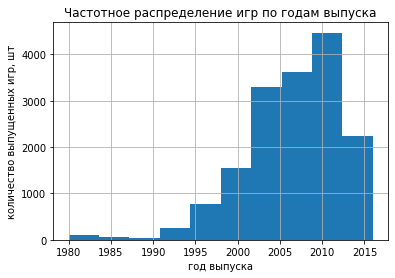

In [17]:
display(df.pivot_table(index='year_of_release', values='name', aggfunc= 'count').T)
df['year_of_release'].hist(bins=10)
plt.xlabel('год выпуска')
plt.ylabel('количество выпущенных игр, шт')
plt.title("Частотное распределение игр по годам выпуска")
plt.show()

Мы видим, что с 1995 по 2009 каждый год количество релизов превышало предыдущий. Однако начиная с 2010 года их количество пошло на спад. Вероятно, это можно объяснить активным развитием игр на смартфонах и планшетах в этот период. **Предварительный ориентир начала актуального периода: с 2010 года и далее, т.е. 7 лет.**

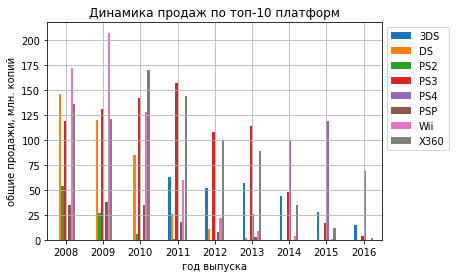

In [18]:
#найдем 10 платформ с наибольшими суммарными продажами и построим по ним распределение 
#продаж по годам, начиная с пикового 2008 года
top_sales = df.pivot_table(index=['platform'], values='total_sales', aggfunc= 'sum').sort_values(by="total_sales",ascending = False)
top_platforms = set(top_sales.head(10).index)
df1 = df.query('year_of_release >= 2008')
df1 = df1[df['platform'].isin(top_platforms)]
df1 = df1.pivot_table(index=['platform'], columns = 'year_of_release', values='total_sales', aggfunc= 'sum')
df1.T.plot.bar(grid=True, rot = 0)
plt.xlabel('год выпуска')
plt.ylabel("общие продажи, млн. копий")
plt.title("Динамика продаж по топ-10 платформ")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

На графике видно, что к 2008 году из 10 платформ с наибольшими продажами за весь период осталось только 8. Определим характерный срок, за который появляются новые и исчезают старые платформы.

In [19]:
#разделим платформы на старые (к 2016 году уже более 3 лет не выпускались новые игры) и актуальные
platforms_actual = set(df.loc[df["year_of_release"] >= 2014]['platform'])
platforms_old = set(df['platform']) - platforms_actual
result = pd.DataFrame()
#напишем функцию, подсчитывающую срок жизни платформы
for platform, z in df.groupby('platform'):  
    T = pd.DataFrame({"platform":[platform], "count":[len(set(z['year_of_release']))]})
    result = result.append(T)

#выведем данные по старым платформам
result_old = result.rename(columns={'platform': 'platforms_old', 'count': 'number_of_years'})
result_old = result_old[result['platform'].isin(platforms_old)]
result_old = result_old.set_index("platforms_old")
display(result_old.T)
display(result_old.describe().T)

platforms_old,2600,3DO,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PCFX,PS,PS2,SAT,SCD,SNES,TG16,WS,XB
number_of_years,10,2,7,11,13,8,7,5,1,7,12,4,1,10,12,6,2,10,1,3,9


,count,mean,std,min,25%,50%,75%,max
number_of_years,21.0,6.714286,4.001785,1.0,3.0,7.0,10.0,13.0


На основании полученных данных можно сделать следующие выводы:
 - общее количество подобных платформ 21 шт.;
 - разброс срока жизни старых платформ от 1 года (платформы PCFX или TG16) до 13 лет (платформа GB);
 - средний срок жизни старых платформ порядка 7 лет.

Чтобы изучить актуальные платформы на 2017 год, достаточно изучить данные начиная с (2017 - х) лет, а более старое, если и было популярно, уже сошло на нет. На основании полученных данных количества выпущенных игр по годам (актуальный период 7 лет), среднем сроке жизни платформ (актуальный период тоже 7 лет), а также принимая во внимание факт, что данные за 2016 год неполные, **актуальный период для наших целей мы можем определить в период в 8 лет. Таким образом, данные ранее 2009 можно откинуть.** Теперь составим топ-5 продаж для актуальных платформ: в них входят PS3, X360, Wii, PS4 и 3DS, однако по всем ним продажи падают.

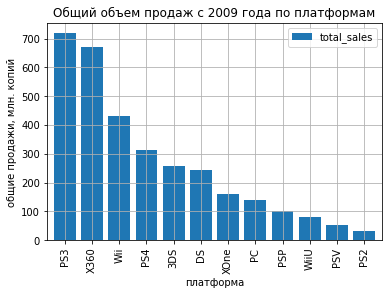

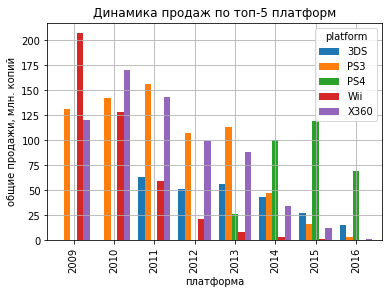

In [20]:
df = df.query('year_of_release >= 2009')
s = df.pivot_table(index=['platform'], values='total_sales', aggfunc= 'sum').sort_values(by="total_sales",ascending = False)
s.plot.bar(width = 0.8, grid=True)
plt.xlabel('платформа')
plt.ylabel("общие продажи, млн. копий")
plt.title("Общий объем продаж с 2009 года по платформам")
top_platforms_actual = set(s.head().index)
m = df[df['platform'].isin(top_platforms_actual)]
m = m.pivot_table(index=['platform'], columns = 'year_of_release', values='total_sales', aggfunc= 'sum')
m.T.plot.bar(width = 0.8, grid=True)
plt.xlabel('платформа')
plt.ylabel("общие продажи, млн. копий")
plt.title("Динамика продаж по топ-5 платформ")
plt.show()

Определим несколько потенциально прибыльных платформ. Так как данные за 2016 год неполные, выведем продажи в разрезе платформ начиная с 2015 года. **На топ-3 (PS4, XOne и 3DS) приходится 80% всех продаж за этот период, поэтому придерживаясь принципа Паретто, их можно рассматривать как потенциально прибыльные.**

In [21]:
df_2015 = df.query('year_of_release >= 2015')
df_2015.pivot_table(index=['platform'], values='total_sales', margins=True, aggfunc= 'sum').sort_values(by="total_sales",ascending = False).T

platform,All,PS4,XOne,3DS,WiiU,PS3,PC,X360,PSV,Wii,PSP
total_sales,397.92,188.15,86.29,42.92,20.95,20.42,13.77,13.48,10.5,1.32,0.12


Построим график «ящик с усами» по глобальным продажам игр.

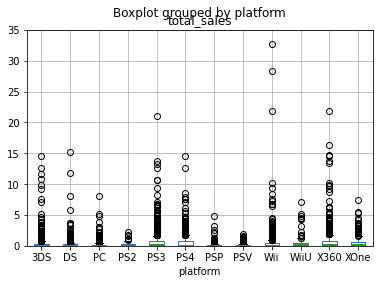

In [22]:
#display(df.pivot_table(index=['platform'], columns = 'year_of_release', values='total_sales', aggfunc= 'max'))
df.boxplot(column = 'total_sales', by = "platform")
plt.ylim(0, 35)
plt.show()

Мы видим, что для всех платформ размах усов уклыдывается в пределах 1-2 млн. проданных копий. При этом для каждой плафтормы наблюдаем значительное количество выбросов - успешные игры, которые выпускались на этих платформах. Максимальные продажи пришлись на игру Wii Sports Resort на платформе Wii в 2009 году - общие продажи составили почти 33  млн. копий (см.ниже). Обратим внимание, что для разных платформ максимальные выбросы могут сильно отличаться. Причин этому может быть сразу несколько: во-первых, использование нами актуального периода начиная с 2009 года отсекают более ранние продажи (PS2 стартовал с продажами в 2000 году); во-вторых, какие-то платформы имеют сравнительно небольшой срок продаж (например, наши лидеры PS4 и XOne начали продаваться только с 2013 г., а 3DS с 2011 г., т.е. к 2016 году у них всего 3 и 5 лет продаж соотвественно); в-третьих, мы видим разные типы платформ - 3DS, DS, PSP и PSV это портативные игровые консоли, а остальные платформ представлены полноценными игровыми приставками, т.е. по сути это разные сегменты компьютерных игр.

In [23]:
df.loc[df["total_sales"] == df['total_sales'].max()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80,8.0,E


Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Наиболее популярная актуальная платформа PS4, проанализируем ее.

0.406567902061781

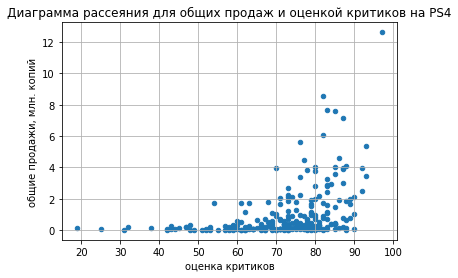

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,97,8.3,M


-0.031957110204556424

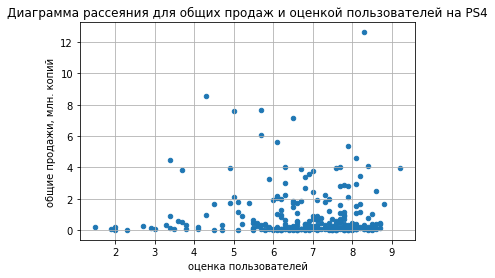

In [24]:
#определим, есть ли зависимость между отзывами пользователей/критиков и продажами. 
#Поскольку по многим играм нет данных по отзывам, оставим только игры, где присутствуют оценки критиков. 
df_PS4 = df.query('platform == "PS4" and critic_score > 0')
display(df_PS4['total_sales'].corr(df['critic_score']))
df_PS4.plot(x='critic_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка критиков')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой критиков на PS4")
plt.show()
display(df_PS4.loc[df_PS4["critic_score"] == df_PS4['critic_score'].max()])
df_PS4 = df.query('platform == "PS4" and user_score > 0')
display(df_PS4['total_sales'].corr(df['user_score']))
df_PS4.plot(x='user_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка пользователей')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой пользователей на PS4")
plt.show()

Для пары продажи - оценка критиков корреляция положительная, а ее уровень можно оценить как средний (0.4). На матрице рассеяния видна общая зависимость: уровень продаж более высокий для игр с высокой оценков критиков. Наибольшие продажи пришлись на игру Grand Theft Auto V с самым высоким рейтингов критиков 97. Никакой зависимости между продажами и оценками пользователей не обнаружено, поскольку коэффициент корреляции стремится к нулю. Это подтверждает и диаграмма рассеяния. Сравним полученные выводы с продажами игр на других популярных платформах.

0.41699832800840175

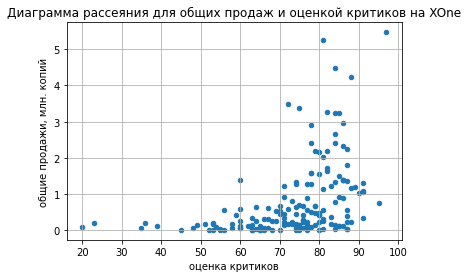

-0.06892505328279412

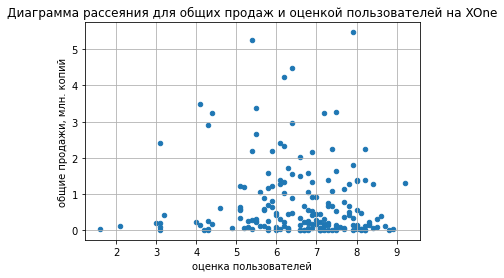

In [25]:
#проверим наличие зависимостей для платформы XOne
df_XOne = df.query('platform == "XOne" and critic_score > 0')
display(df_XOne['total_sales'].corr(df['critic_score']))
df_XOne.plot(x='critic_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка критиков')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой критиков на XOne")
plt.show()
df_XOne = df.query('platform == "XOne" and user_score > 0')
display(df_XOne['total_sales'].corr(df['user_score']))
df_XOne.plot(x='user_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка пользователей')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой пользователей на XOne")
plt.show()

0.34873973059848346

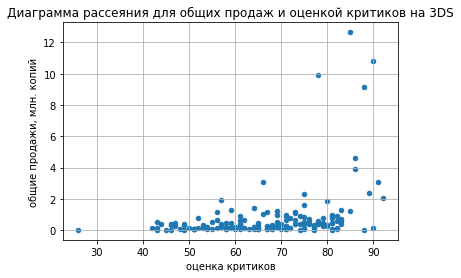

0.22207843643390884

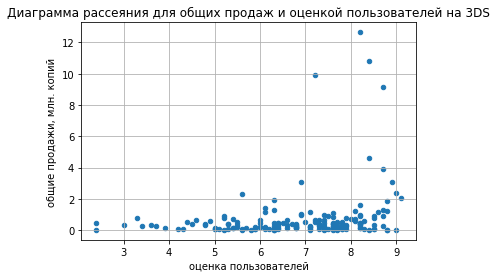

In [26]:
#проверим наличие зависимостей для платформы 3DS
df_3DS = df.query('platform == "3DS" and critic_score > 0')
display(df_3DS['total_sales'].corr(df['critic_score']))
df_3DS.plot(x='critic_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка критиков')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой критиков на 3DS")
plt.show()
df_3DS = df.query('platform == "3DS" and user_score > 0')
display(df_3DS['total_sales'].corr(df['user_score']))
df_3DS.plot(x='user_score', y='total_sales', kind='scatter', grid=True)
plt.xlabel('оценка пользователей')
plt.ylabel('общие продажи, млн. копий')
plt.title("Диаграмма рассеяния для общих продаж и оценкой пользователей на 3DS")
plt.show()

В целом мы получили аналогичные PS4 результаты для платформ XOne и 3DS: 
  - корреляция  между продажами и оценкой критиков положительная, а ее уровень можно оценить как средний (0,35 - 0.4);
  - корреляция  между продажами и оценкой пользователей отсутствует или выражена очень слабо (0 для PS4 и XOne, 0.22 для 3DS ).

Возможно, подобный результат можно объяснить, что в процессе выбора пользователи смотрят в первую очередь профессиональные обзоры игр с хорошей оценкой критиков, нежели полагаются на отзывы таких же пользователей, как они.

Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

genre,All,Action,Shooter,Sports,Role-Playing,Misc,Platform,Racing,Fighting,Simulation,Adventure,Strategy,Puzzle
total_sales,3203.06,810.78,549.03,465.76,362.59,310.37,160.25,156.37,113.49,104.67,81.23,48.13,40.39


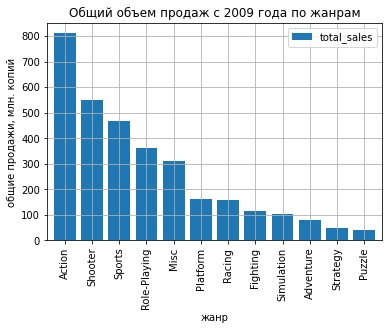

In [27]:
#построим диаграмму общих продаж в разрезе жанров
display(df.pivot_table(index=['genre'], values='total_sales', margins=True, aggfunc= 'sum').sort_values(by="total_sales",ascending = False).T)
df.pivot_table(index=['genre'], values='total_sales', aggfunc= 'sum').sort_values(by="total_sales",ascending = False).plot.bar(width = 0.8, grid=True)
plt.xlabel('жанр')
plt.ylabel('общие продажи, млн. копий')
plt.title("Общий объем продаж с 2009 года по жанрам")
plt.show()

Наиболее продаваемые жанры Action, Shooter, Sports, Role-Playing и Misc: на них пришлось порядка 80% всех продаж в мире. Самый популярный жанр Action - на него пришлось 25% от всех продаж. Наименее популярны жанры Strategy и Puzzle - каждый имеет менее 50 млн. проданных копий, или менее 1,5% от всех продаж. Стоит отметить большой разрыв между продажами жанра Misc и следующим по объемам Platform - они ниже почти в 2 раза.

**Определите для пользователя каждого региона (NA, EU, JP):**
 -	Самые популярные платформы (топ-5). Опишите различия в долях продаж.
 -	Самые популярные жанры (топ-5). Поясните разницу.
 -	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

platform,X360,PS3,Wii,DS,PS4
na_sales,408.180000,291.900000,235.750000,120.610000,108.740000
ratio,0.278439,0.199119,0.160816,0.082274,0.074177


platform,PS3,X360,PS4,Wii,PC
eu_sales,255.000000,196.720000,141.090000,124.220000,82.320000
ratio,0.247777,0.191148,0.137094,0.120702,0.079988


platform,3DS,PS3,DS,PSP,Wii
jp_sales,100.620000,68.290000,52.110000,50.390000,34.320000
ratio,0.274147,0.186061,0.141977,0.137291,0.093507


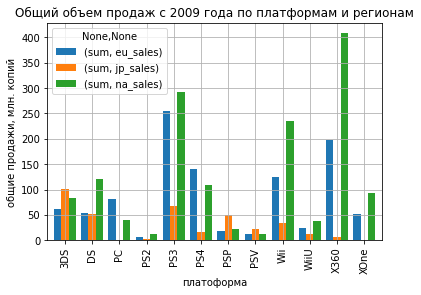

In [28]:
#определим наиболее популярные платформы по регионам
#для Северной Америки
na_sales = pd.DataFrame(df.groupby('platform')['na_sales'].sum())
na_sales['ratio'] = na_sales['na_sales'].apply(lambda x: x/df['na_sales'].sum())
display(na_sales.sort_values(by="na_sales",ascending = False).head().T)
#для Европы
eu_sales = pd.DataFrame(df.groupby('platform')['eu_sales'].sum())
eu_sales['ratio'] = eu_sales['eu_sales'].apply(lambda x: x/df['eu_sales'].sum())
display(eu_sales.sort_values(by="eu_sales",ascending = False).head().T)
#для Японии
jp_sales = pd.DataFrame(df.groupby('platform')['jp_sales'].sum())
jp_sales['ratio'] = jp_sales['jp_sales'].apply(lambda x: x/df['jp_sales'].sum())
display(jp_sales.sort_values(by="jp_sales",ascending = False).head().T)
#построим график продаж по платформам для трех регионов
df.pivot_table(index=['platform'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc= ['sum']).plot.bar(width = 0.8, grid=True)
plt.xlabel('платоформа')
plt.ylabel('общие продажи, млн. копий')
plt.title("Общий объем продаж с 2009 года по платформам и регионам")
plt.show()

Мы видим, что во всех трех регионах лидеры продаж по платформам различаются: в Северной Америке наиболее популярная платформа X360 (28% от всех продаж региона), в Европе это PS3 с долей 25%, а в Японии 3DS с долей в 27%. Стоит отметить, что платформы PS3 и Wii присутствуют в топ-5 во всех трех регионах.

genre,Action,Shooter,Sports,Misc,Role-Playing
na_sales,361.720000,276.370000,227.660000,164.400000,130.830000
ratio,0.246746,0.188525,0.155298,0.112145,0.089245


genre,Action,Shooter,Sports,Misc,Role-Playing
eu_sales,271.910000,192.300000,158.51000,86.270000,83.560000
ratio,0.264208,0.186853,0.15402,0.083826,0.081193


genre,Role-Playing,Action,Misc,Sports,Platform
jp_sales,120.610000,84.1600,30.090000,25.320000,20.650000
ratio,0.328611,0.2293,0.081982,0.068986,0.056262


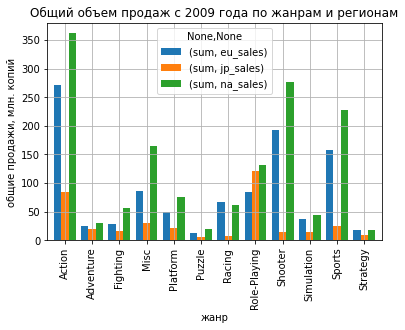

In [29]:
#определим наиболее популярные жанры по регионам
#для Северной Америки
na_sales = pd.DataFrame(df.groupby('genre')['na_sales'].sum())
na_sales['ratio'] = na_sales['na_sales'].apply(lambda x: x/df['na_sales'].sum())
display(na_sales.sort_values(by="na_sales",ascending = False).head().T)
#для Европы
eu_sales = pd.DataFrame(df.groupby('genre')['eu_sales'].sum())
eu_sales['ratio'] = eu_sales['eu_sales'].apply(lambda x: x/df['eu_sales'].sum())
display(eu_sales.sort_values(by="eu_sales",ascending = False).head().T)
#для Японии
jp_sales = pd.DataFrame(df.groupby('genre')['jp_sales'].sum())
jp_sales['ratio'] = jp_sales['jp_sales'].apply(lambda x: x/df['jp_sales'].sum())
display(jp_sales.sort_values(by="jp_sales",ascending = False).head().T)
#построим график продаж по жанрам для трех регионов
df.pivot_table(index=['genre'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc= ['sum']).plot.bar(width = 0.8, grid=True)
plt.xlabel('жанр')
plt.ylabel('общие продажи, млн. копий')
plt.title("Общий объем продаж с 2009 года по жанрам и регионам")
plt.show()

Топ-5 жанров в Северной Америке и Европе полностью совпадают, причем даже в долях продаж. Это может объясняться общим "западным образом мышления" этих регионов. Наиболее популярный жанр Action. Однако в Японии лидирует жанр Role-Playing. Стоит также отметить здесь популярность в Японии жанра Platform, который отсутствует в топ-5 Северной Америки и Европе. В целом 3 жанра из топ-5 присутствуют во всех регионах: это Action, Misc и Sports

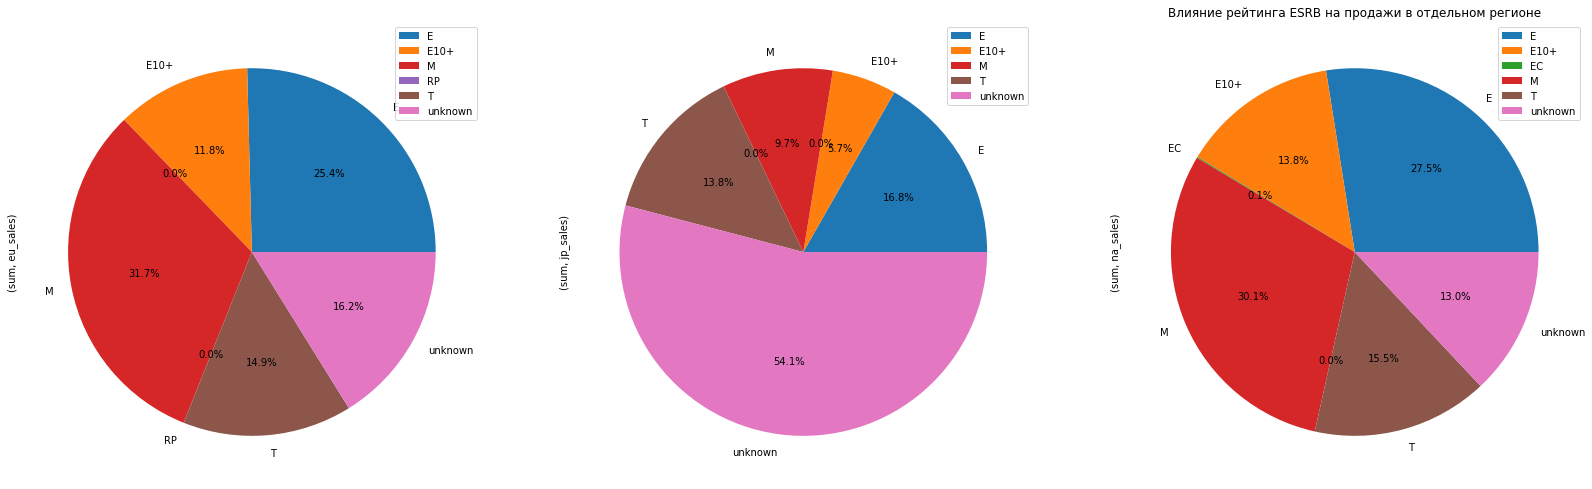

In [30]:
m = df.pivot_table(index=['rating'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc= ['sum'])
m.plot.pie(subplots=True, autopct='%1.1f%%', figsize=(28, 28))
plt.title("Влияние рейтинга ESRB на продажи в отдельном регионе")
plt.show()

Что касается вопроса влияния рейтинга ESRB на продажи в отдельном регионе, мы можем сделать вывод, что для Америки и Европы наличие рейтинга сильно влияет на продажи, поскольку для многих типов рейтинга продажи по ним либо превышают, либо сопоставимы с продажами игр без рейтингов. Однако и здесь выделилась Япония, более половины всех продаж пришлось на игры, у которых рейтинг отсутствует. Можно предположить, что причина снова кроется в природе рейтинга - ESRB определяет рейтинги для игр в США и Канаде, в то время как в Японии это делает CERO, по которой у нас нет данных.

##  Проверка гипотез

Проверим гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". Поскольку H₀ всегда формулируется так, чтобы использовать знак равенства, то это нулевая гипотеза. Альтернативная гипотеза звучит так: "Средние пользовательские рейтинги платформ Xbox One и PC различаются". Для проверки проведем статистический тест на равенство среднего двух генеральных совокупностей по взятым из них выборкам.


In [31]:
#сравним выборки для платформ Xbox One и PC с пользовательским рейтингом выше 0
df_us = df.query('year_of_release >= 2008 and user_score > 0 and (platform == "XOne" or platform == "PC")')
df_us.pivot_table(index=['platform'], values= ['user_score'], aggfunc= ['count','mean'])
#df_us

,count,mean
,user_score,user_score
platform,,
PC,457,6.652079
XOne,182,6.521429


Мы видим, что наши выборки разного размера (457 для платформы PC vs 182 для XOne), а значит дисперсии одних и тех же показателей может сильно различаться. В связи с этим  при проведении статистического теста параметр equal_var нужно указать False, чтобы тест посчитал дисперсии выборок по отдельности.
Средние оценки для обеих платформ очень близки.

In [32]:
df_PC = df_us[df_us['platform'] == "PC"]['user_score']
df_XOne = df_us[df_us['platform'] == "XOne"]['user_score']
alpha = .001
results = st.ttest_ind(df_PC, df_XOne, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.29856178733970584
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 30%, что значительно выше критического уровня значимости даже в 5%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними оценками пользователей для этих плаформ. Таким образом, **оснований отвергать гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" нет**.

Теперь проверим еще одну гипотезу - "Средние пользовательские рейтинги жанров Action и Sports разные". А это уже альтернативная гипотеза в противовес нулевой, которая звучит так: "Средние пользовательские рейтинги жанров Action и Sports не отличаются друг от друга".

In [33]:
#сравним выборки для жанров Action и Sports, с пользовательским рейтингом выше 0
df2 = df.query('year_of_release >= 2008 and user_score > 0 and (genre == "Action" or genre == "Sports")')
df2.pivot_table(index=['genre'], values= ['user_score'], aggfunc= ['count','mean'])
#df2

,count,mean
,user_score,user_score
genre,,
Action,936,6.817415
Sports,400,6.105250


И вновь наши выборки сильно различаются по размеру (936 для жанра Action vs 400 для Sports). В связи с этим  при проведении статистического теста параметр equal_var нужно указать False, чтобы тест посчитал дисперсии выборок по отдельности. Средние оценки отличаются уже сильнее, чем при проверке предыдущей гипотезы.

In [34]:
df_action = df2[df2['genre'] == "Action"]['user_score']
df_sports = df2[df2['genre'] == "Sports"]['user_score']
alpha = .001
results = st.ttest_ind(df_action, df_sports, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.493323839142059e-13
Отвергаем нулевую гипотезу


**По результатам проведения теста значение p-value стремится к нулю (10^-13). Таким образом, оснований отвергать гипотезу "Средние пользовательские рейтинги жанров Action и Sports разные" нет**.

## Общий вывод

На основании проведенного анализа можно сделать следующие выводы:
1. С 1991 по 2009 почти каждый год количество релизов превышало предыдущий. Однако начиная с 2010 года их количество пошло на спад. Вероятно, это можно объяснить активным развитием игр на смартфонах и планшетах в этот период.
2. На топ-3 платформ: PS4, XOne и 3DS - приходится 80% всех продаж за период начиная с 2015 года, поэтому придерживаясь принципа Паретто, их можно рассматривать как потенциально прибыльные.
3. На основании диаграммы размаха мы определили, что для всех платформ размах усов уклыдывается в пределах 1-2 млн. проданных копий, это среднестатистический объем продаж для среднестатистической игры. Однако для каждой плафтормы существуют выбросы - успешные игры, которые выпускались на этих платформах. Максимальные продажи пришлись на игру Wii Sports Resort на платформе Wii в 2009 году - общие продажи составили почти 33  млн. копий.
4. Мы получили следующие результаты влияния отзывов критиков и пользователей на продажи: 
  - корреляция  между продажами и оценкой критиков положительная, а ее уровень можно оценить как средний (0,35 - 0.4);
  - корреляция  между продажами и оценкой пользователей отсутсвует или выражена очень слабо (0 для PS4 и XOne, 0.22 для 3DS ).
5. Наиболее продаваемые жанры Action, Shooter, Sports, Role-Playing и Misc: на них пришлось порядка 80% всех продаж в мире. Самый популярный жанр Action - на него пришлось 25% от всех продаж. Наименее популярны жанры Strategy и Puzzle - каждый имеет менее 50 млн. проданных копий, или менее 1,5% от всех продаж.
6. Мы составили портрет пользователя для трех регионов Северная Америка, Европа и Япония:
* во всех трех регионах лидеры продаж по платформам различаются: в Северной Америке наиболее популярная платформа X360 (28% от всех продаж региона), в Европе это PS3 с долей 25%, а в Японии 3DS с долей в 27%. Стоит отметить, что платформы PS3 и Wii присутствуют в топ-5 во всех трех регионах;
* топ-5 жанров в Северной Америке и Европе полностью совпадают, причем даже в долях продаж. Это может объясняться общим "западным образом мышления" этих регионов. Наиболее популярен жанр Action. Однако в Японии лидирует жанр Role-Playing. Стоит также отметить здесь популярность в Японии жанра Platform, который отсутствует в топ-5 Северной Америки и Европе. В целом 3 жанра из топ-5 присутсвуют во всех регионах: это Action, Misc и Sports;
* что касается вопроса влияния рейтинга ESRB на продажи в отдельном регионе, мы можем сделать вывод, что для Америки и Европы наличие рейтинга сильно влияет на продажи, поскольку для многих типов рейтинга продажи по ним либо превышают, либо сопоставимы с продажами игр без рейтингов. Однако и здесь выделилась Япония, более половины всех продаж пришлось на игры, у которых рейтинг отсутствует. Можно предположить, что причина кроется в природе рейтинга - ESRB определяет рейтинги для игр в США и Канаде, в то время как в Японии это делает CERO, по которой у нас нет данных.
7.  Мы проверили две гипотезы с помощью статистического теста по проверке равенства среднего двух генеральных совокупностей по взятым из них выборкам. Результаты теста не позволили отвергнуть наши гипотезы:
 - "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые";
 - "Средние пользовательские рейтинги жанров Action и Sports разные".